# Classification
( Based on the incident time and location estimate the probability of guns being involved. )

In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
year = 2005

data = pd.read_csv('data/F{}.csv'.format(year))
data = data[(data['violent'] == 1) & (data['hour'] > 0) & (data['weekday'] > 0)\
                        & (data['zip'] > 0) & (data['year'] >= year)]
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
zip,38764.0,91146.336266,1163.202016,90000.000000,90221.000000,90712.000000,91744.000000,93591.000000
year,38764.0,2005.000000,0.000000,2005.000000,2005.000000,2005.000000,2005.000000,2005.000000
month,38764.0,6.540321,3.401516,1.000000,4.000000,7.000000,9.000000,12.000000
day,38764.0,15.654318,8.780838,1.000000,8.000000,16.000000,23.000000,31.000000
weekday,38764.0,3.526700,1.692809,1.000000,2.000000,4.000000,5.000000,6.000000
hour,38764.0,13.835274,6.783449,0.003056,9.000000,15.000000,19.500000,23.983333
longitude,38764.0,-118.193889,0.181527,-118.912920,-118.265240,-118.177401,-118.084624,-117.110000
latitude,38764.0,34.108614,0.273648,32.690000,33.906483,34.010343,34.193479,34.828569
gang_related,38764.0,0.078397,0.268800,0.000000,0.000000,0.000000,0.000000,1.000000
aggravated,38764.0,0.183882,0.387393,0.000000,0.000000,0.000000,0.000000,1.000000


In [3]:
for year in range(year + 1, 2016):
    df = pd.read_csv('data/F{}.csv'.format(year))
    df = df[(df['violent'] == 1) & (df['hour'] > 0) & (df['weekday'] > 0) & (df['zip'] > 0) & (df['year'] >= year)]
    data = data.append(df, ignore_index = True)

data.shape

(402498, 19)

In [4]:
data.columns

Index(['category', 'city', 'zip', 'year', 'month', 'day', 'weekday', 'hour',
       'longitude', 'latitude', 'gang_related', 'aggravated', 'incident_date',
       'gun', 'shooting', 'knife', 'carjacking', 'kidnapping', 'violent'],
      dtype='object')

In [5]:
data['category'] = data.apply(lambda r: 'kidnapping' if r['kidnapping'] == 1 else r['category'], axis = 1)
data.groupby('category').size()

category
arson           5402
assault       193688
burglary       83437
homicide        1959
kidnapping       710
rape            4182
robbery        47218
vandalism      65902
dtype: int64

We've got highly imbalanced representation.

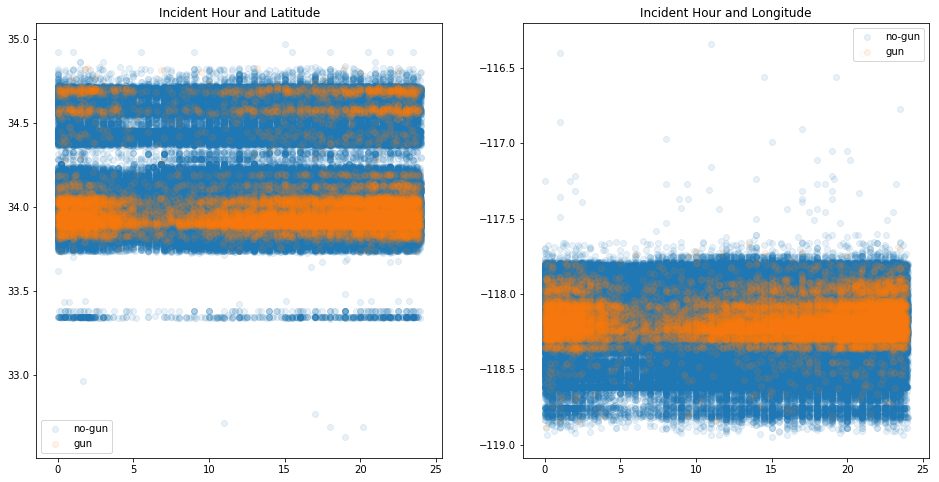

In [6]:
plt.rcParams['figure.figsize'] = (16, 8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax = ax.flatten()

ax[0].set_title('Incident Hour and Latitude')
ax[1].set_title('Incident Hour and Longitude')

for v in [0,1]:
    d = data[data['gun'] == v]
    label = 'gun' if v == 1 else 'no-gun'
    ax[0].scatter(d['hour'].values, d['latitude'].values, alpha = 0.1, label = label)
    ax[1].scatter(d['hour'].values, d['longitude'].values, alpha = 0.1, label = label)

ax[0].legend()
ax[1].legend()
plt.show()

In [7]:
data.groupby('gun').size()

gun
0    389511
1     12987
dtype: int64

In [8]:
features = ['hour','weekday','longitude','latitude']
X = data[features].as_matrix()
X.shape

(402498, 4)

In [9]:
Y = data['gun'].as_matrix()
Y.shape

(402498,)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 11)

In [11]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

### 1. Logistic Regression with Upsampled Minority

In [12]:
major = X_train[Y_train == 0]
minor = X_train[Y_train == 1]
 
# upsample minority class
upsampled = resample(minor, replace = True, n_samples = len(major), random_state = 11)
 
X_train_upsampled = np.concatenate((major, upsampled), axis = 0)
Y_train_upsampled = np.concatenate((np.zeros((len(major))), np.ones((len(major)))), axis = 0)

In [14]:
clf = LogisticRegression().fit(X_train_upsampled, Y_train_upsampled)
prediction = clf.predict(X_train_upsampled)
print(accuracy_score(prediction, Y_train_upsampled))
print(np.unique(prediction))

0.608445906304
[ 0.  1.]


In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
probability = [p[1] for p in clf.predict_proba(X_train_upsampled)]
print(roc_auc_score(Y_train_upsampled, probability))

0.634771188758


### 2. Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, Y_train)

prediction = rf.predict(X_train)
print( accuracy_score(Y_train, prediction))
print(np.unique(prediction))

probability = [p[1] for p in rf.predict_proba(X_train)]
print(roc_auc_score(Y_train, probability))

0.999797691554
[0 1]
0.999999498017


In [19]:
probability = [p[1] for p in rf.predict_proba(X_test)]
print(roc_auc_score(Y_test, probability))

0.731780065137
